# Features after Manufacturing

Comparison across two different datasets.

Andrew Weng

9/20/2020

In [1]:
import os, sys

if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('../')
    sys.path.insert(0, 'src/')

import numpy as np
import pandas as pd
import yaml
import seaborn as sns

from scipy.stats import pearsonr, ttest_ind
from scipy import interpolate
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt

from src.utils import get_label_registry
import src.plotter as plotter

import warnings
warnings.filterwarnings('ignore')

In [2]:
plotter.initialize(plt)
paths = yaml.load(open('paths.yaml', 'r'), Loader=yaml.FullLoader)
output_path = f"{paths['outputs']}/2022-08-25-manufacturing-features"

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50)

## Configure globals

In [3]:
# Formation types
COLOR_BASE = np.array([0, 0, 0])
COLOR_FAST = np.array([44, 121, 245])/255
COLOR_FAST_RT = np.array([0, 0, 1])
COLOR_FAST_HT = np.array([1, 0, 0])
LINESTYLE_BASE = ':'
LINESTYLE_FAST = '-'

# Pos/neg electrode colors
COLOR_POS = np.array([0, 0, 1])
COLOR_NEG = np.array([1, 0, 0])
COLOR_FULL_CELL = np.array([0, 0, 0])

COLOR_REF = (0.7, 0.7, 0.7)

NOMINAL_CAPACITY_AH = 2.36
CAPACITY_LIMITS_AH = (0.8, 2.4)
TARGET_RETENTION = 0.7

# Load the correlation data

In [83]:
paths = yaml.load(open('paths.yaml', 'r'), Loader=yaml.FullLoader)

# Weng2021 dataset
path = paths['outputs'] + 'summary_esoh_table.csv'
df_weng2021 = pd.read_csv(path)
df_weng2021 = df_weng2021[df_weng2021['cycle_number'] == 3]
df_weng2021.head()

# Label by test temperature
for i, row in df_weng2021.iterrows():
    if row['cellid'] in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]:
        df_weng2021.at[i, 'Source'] = 'Weng2021 (HT)'
    else:
        df_weng2021.at[i, 'Source'] = 'Weng2021 (RT)'

# Mohtat2021 dataset
path = paths['outputs'] + 'summary_esoh_table_mohtat2021.csv'
df_mohtat2021 = pd.read_csv(path)
df_mohtat2021 = df_mohtat2021[df_mohtat2021['cycle_number'] == 0]
df_mohtat2021['Source'] = 'Mohtat2021 (RT)'
df_mohtat2021.head()

# Merge the datasets
df = pd.concat([df_mohtat2021, df_weng2021])
df['npr'] = 1 + df['neg_excess'].values / df['Qfull'].values 
df['Cli'] = df['n_li'].values / 3600 * 96500

df['Cpnorm'] = df['Cp'] / df['Qfull']
df['Cnnorm'] = df['Cn'] / df['Qfull']
df['Clinorm'] = df['Cli'] / df['Qfull']

df

,cellid,cycle_number,y100,Cp,x100,Cn,Qcomp,x0,y0,Qfull,pos_excess,neg_excess,RMSE_mV,np_ratio,n_li,LLI,LAM_PE,LAM_NE,C20_loss,Cn_pf,x100_pf,Source,n_li_graphical,npr,Cli,Cpnorm,Cnnorm,Clinorm
0,1,0,0.032577,5.960533,0.843688,6.034017,0,-0.001520,0.888205,5.10,0.6800,1.1800,6.030346,1.012328,0.197191,1.0,0.0,0.0,1.0,6.069221,0.835721,Mohtat2021 (RT),NaN,1.231373,5.285823,1.168732,1.183141,1.036436
11,2,0,0.032157,5.930057,0.838197,6.069130,0,-0.000473,0.890496,5.09,0.6600,1.2200,6.187240,1.023452,0.196923,1.0,0.0,0.0,1.0,5.286585,0.877649,Mohtat2021 (RT),NaN,1.239686,5.278642,1.165041,1.192363,1.037061
26,3,0,0.032792,5.755256,0.828180,5.973876,0,0.002920,0.889400,4.93,0.6500,1.2600,5.198046,1.037986,0.191638,1.0,0.0,0.0,1.0,5.262626,0.865850,Mohtat2021 (RT),NaN,1.255578,5.136972,1.167395,1.211740,1.041982
36,4,0,0.032628,5.919029,0.838451,6.036464,0,-0.001445,0.889187,5.07,0.6700,1.2100,5.715719,1.019840,0.196050,1.0,0.0,0.0,1.0,5.330718,0.874708,Mohtat2021 (RT),NaN,1.238659,5.255218,1.167461,1.190624,1.036532
45,5,0,0.032382,5.934842,0.842606,6.045651,0,-0.000976,0.891714,5.10,0.6600,1.1900,5.878350,1.018671,0.197239,1.0,0.0,0.0,1.0,5.261702,0.884101,Mohtat2021 (RT),NaN,1.233333,5.287105,1.163694,1.185422,1.036687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,36,3,0.037566,2.753035,0.918105,2.762990,0,0.006049,0.952920,2.52,0.1388,0.3316,20.600371,1.003616,0.098507,1.0,0.0,0.0,1.0,2.847647,0.893858,Weng2021 (HT),0.098507,1.131587,2.640546,1.092474,1.096425,1.047836
228,37,3,0.036890,2.727753,0.915881,2.731011,0,0.007792,0.946063,2.48,0.1563,0.3338,16.582236,1.001194,0.097081,1.0,0.0,0.0,1.0,2.848704,0.885916,Weng2021 (HT),0.097081,1.134597,2.602312,1.099900,1.101214,1.049319
234,38,3,0.039049,2.730355,0.923018,2.741089,0,0.010972,0.954681,2.50,0.1329,0.3155,33.190599,1.003931,0.098379,1.0,0.0,0.0,1.0,2.825416,0.899008,Weng2021 (HT),0.098379,1.126200,2.637103,1.092142,1.096435,1.054841
240,39,3,0.037588,2.722508,0.919955,2.728052,0,0.007216,0.952186,2.49,0.1393,0.3224,24.642722,1.002036,0.097458,1.0,0.0,0.0,1.0,2.839622,0.890843,Weng2021 (HT),0.097458,1.129478,2.612424,1.093377,1.095603,1.049166


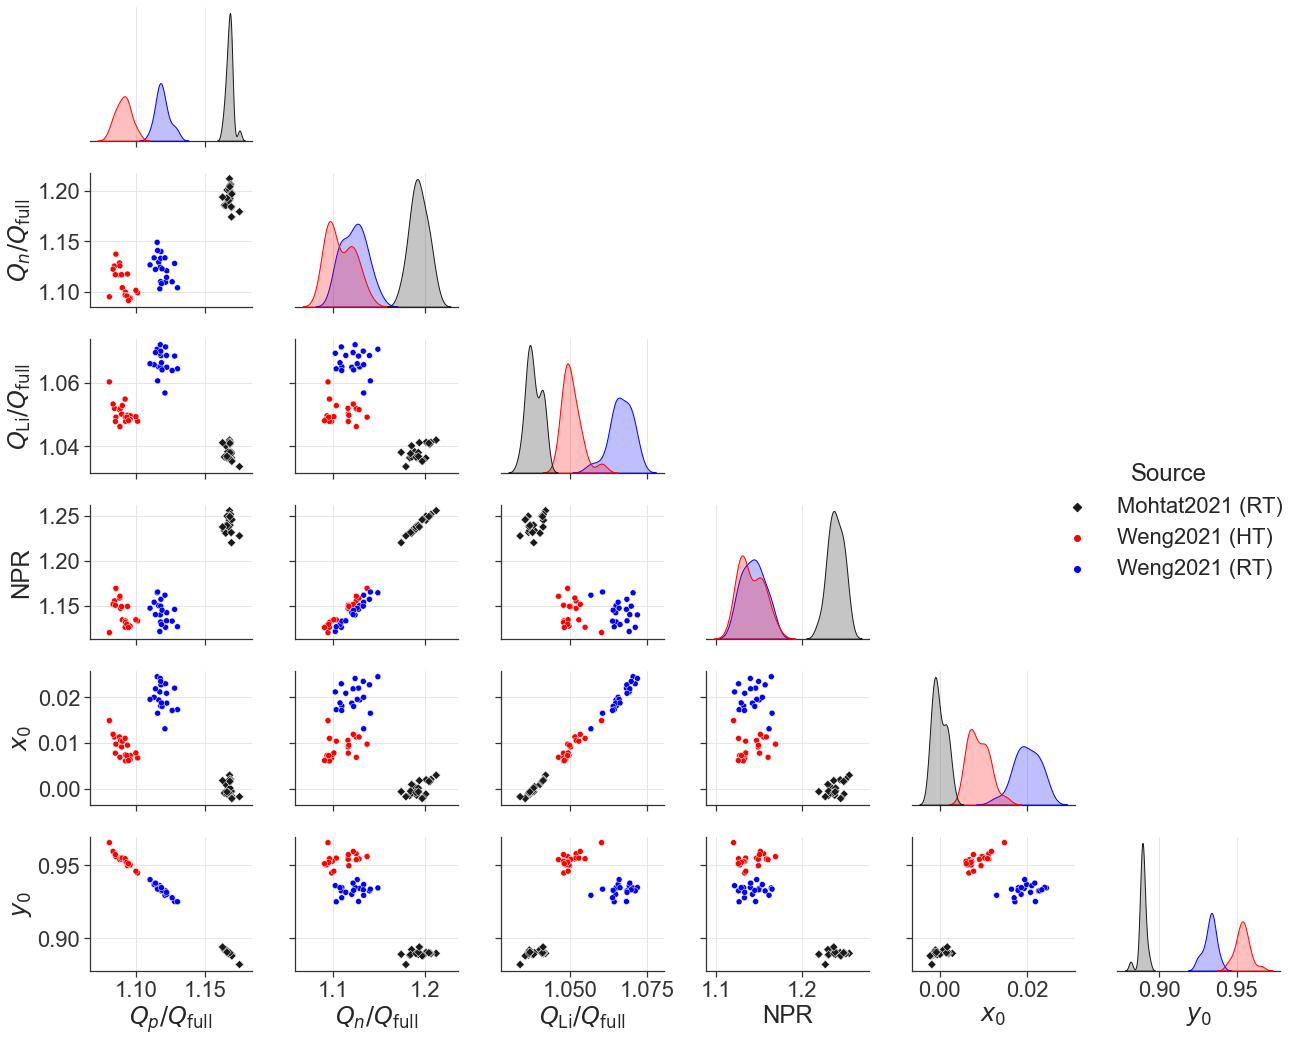

In [93]:
custom_params = {"grid.color" : "0.9",
                 "axes.facecolor" : "w",
                 "axes.edgecolor" : "0.2",
                 "xtick.color" : "0.2",
                 "xtick.bottom" : True,
                 "ytick.color" : "0.2",
                 "ytick.left" : True}

sns.set(font='Arial',
        font_scale=2,
        palette=['k', (1, 0, 0), (0, 0, 1)],
        color_codes=True,
        rc=custom_params)

vars_to_plot = ['Cpnorm', 
                'Cnnorm', 
                'Clinorm', 
                'npr', 
                'x0', 
                'y0']

# Generate the plot
g = sns.pairplot(df, vars=vars_to_plot,
                        hue='Source',
                        diag_kind='auto',
                        markers=['D', 'o', 'o'],
                        corner=True)

# Prettify axis labels
replacements = {'Cpnorm': r'$Q_p/Q_{\mathrm{full}}$', 
                'Cnnorm': r'$Q_n/Q_{\mathrm{full}}$',
                'Clinorm': r'$Q_{\mathrm{Li}}/Q_{\mathrm{full}}$',
                'npr': 'NPR',
                'x0' : '$x_0$',
                'y0' : '$y_0$'}

for i in range(len(vars_to_plot)):
    for j in range(len(vars_to_plot)):
        try:
            xlabel = g.axes[i][j].get_xlabel()
            ylabel = g.axes[i][j].get_ylabel()
        except:
            xlabel = '' 
            ylabel = '' 
        
        if xlabel in replacements.keys():
            g.axes[i][j].set_xlabel(replacements[xlabel])
        if ylabel in replacements.keys():
            g.axes[i][j].set_ylabel(replacements[ylabel])

g.fig.savefig(f'{output_path}/fig_correlations_manufacturing.png', dpi=300)